# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Interpret the predictions made by the model
* Visualize the filters of the Graph Convolution
* Do a TSNE plot of the last layer

In [20]:
import numpy as np
import pandas as pd
#import my_gcn
import random, h5py
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gcn.utils import *
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
import seaborn
import matplotlib.mlab as mlab

from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score

import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

In [2]:
model_dir = '../data/GCN/training/2018_02_02_11_56_50/'
data_file = '../data/preprocessing/legionella_gcn_input_unbalanced.h5'
CLASSIFICATION_THRESHOLD = 0.5

with h5py.File(data_file, 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [13]:
# load predictions
predictions = pd.DataFrame.from_csv(model_dir + '/predictions.tsv', sep='\t', header=0)
print (predictions.sum(axis=0))
pos_predicted = predictions[predictions.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID', 'Name'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0])
labels_df['train_pos'] = y_train[:, 0]
labels_df['test_pos'] = y_test[:, 0]
labels_df['label'] = train_mask.astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_predicted.sort_values(by='Prob_pos', ascending=False).to_csv(model_dir + '/positive_prediction.txt', sep='\t')
pos_predicted.sort_values(by='Prob_pos', ascending=False).head(20)

Name        TSPAN6DPM1SCYL3FGRCFHGCLCNFYALAS1LSEMA3FCFTRCY...
Prob_pos                                              804.263
dtype: object
Predicted 698 genes of 10823 total to be involved in infection


,Name,Prob_pos
ID,,
ENSG00000100625,SIX4,1.000
ENSG00000132002,DNAJB1,1.000
ENSG00000119630,PGF,0.999
ENSG00000198576,ARC,0.999
ENSG00000184545,DUSP8,0.999
ENSG00000128591,FLNC,0.999
ENSG00000109846,CRYAB,0.999
ENSG00000146233,CYP39A1,0.999
ENSG00000013588,GPRC5A,0.999


In [14]:
labels_with_pred = labels_df.join(predictions)
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.test_pos == 1]
pred_pos_train = true_positives[true_positives.train_pos == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} true negatives ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
predictions_for_pos.sort_values(by='Prob_pos', ascending=False)

Predicted 27 out of 38 known infection genes
Out of these 38, 15 were not shown during training.
Predicted 10 out of 15 test genes (66.66666666666666%)
Predicted 17 out of 23 train genes (73.91304347826086%)
Correctly rejected 6063 out of 6470 true negatives (93.70942812982999%)


,positive,train_pos,test_pos,label,negative,Name,Prob_pos
ENSG00000110944,1,0,1,0,0,IL23A,0.998
ENSG00000144381,1,0,1,0,0,HSPD1,0.997
ENSG00000086061,1,1,0,1,0,DNAJA1,0.997
ENSG00000105993,1,1,0,1,0,DNAJB6,0.997
ENSG00000090339,1,1,0,1,0,ICAM1,0.994
ENSG00000160570,1,1,0,1,0,DEDD2,0.994
ENSG00000125538,1,1,0,1,0,IL1B,0.993
ENSG00000149257,1,0,1,0,0,SERPINH1,0.992
ENSG00000013441,1,1,0,1,0,CLK1,0.991
ENSG00000099860,1,0,1,0,0,GADD45B,0.991


ACCURACY: 0.9369860482306199


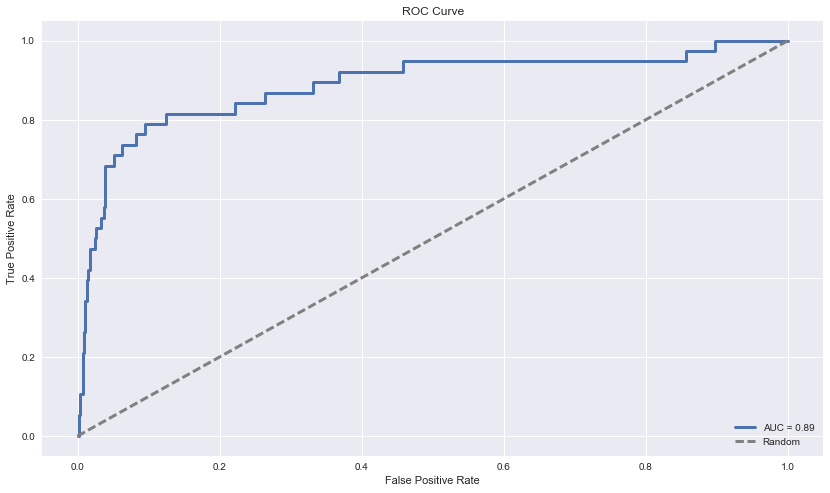

In [19]:
y = np.logical_or(y_train, y_test)
fpr, tpr, thresholds = roc_curve(y[:, 0], predictions.Prob_pos)
roc_auc = roc_auc_score(y[:, 0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=3, label='AUC = {0:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
fig.savefig(model_dir + 'roc_curve.png')
acc = accuracy_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

Precision: 0.03868194842406877	Recall: 0.7105263157894737


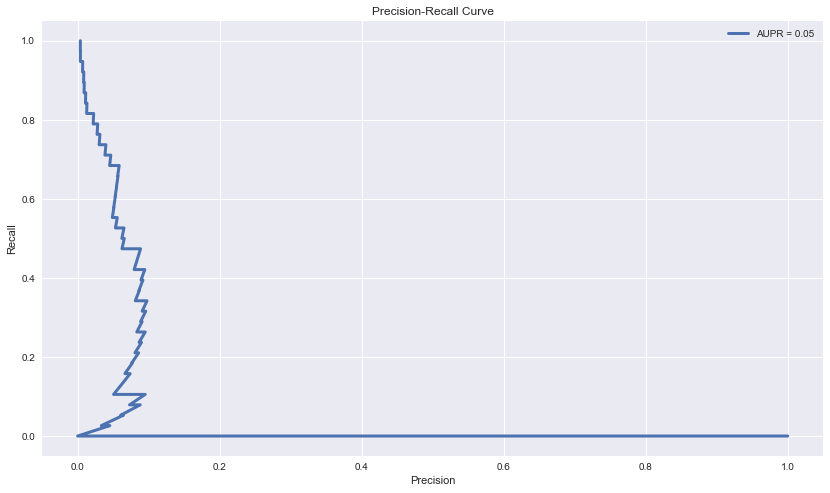

In [18]:
pr, rec, thresholds = precision_recall_curve(y[:, 0], predictions.Prob_pos)
aupr = average_precision_score(y[:,0], predictions.Prob_pos)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rec, lw=3, label='AUPR = {0:.2f}'.format(aupr))
#plt.plot([0, 1], [0, 1], color='gray', lw=3, linestyle='--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend()
fig.savefig(model_dir + 'prec_recall.png')
recall = recall_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
precision = precision_score(y_true=y, y_pred=predictions.Prob_pos >= CLASSIFICATION_THRESHOLD)
print ("Precision: {}\tRecall: {}".format(precision, recall))

## Investigate New Model GCN Parameters

In [7]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
checkpoint_path = os.path.join(model_dir, "model.ckpt")
print_tensors_in_checkpoint_file(file_name=checkpoint_path, tensor_name='', all_tensors=True)


tensor_name:  mygcn/gclayer_1_vars/weights_0:0
[[-0.03383026  0.3963802   0.16901742  0.00257909  0.02163274  0.31281975
   0.13598278  0.03020949  0.27447847 -0.11906227  0.03924361  0.15293075
   0.274028    0.4197205   0.02923355 -0.06730405 -0.09902167 -0.07006898
  -0.10143489  0.33195347 -0.17903292  0.29134488  0.11993994  0.3359105
   0.23561473 -0.15955769 -0.03723606 -0.01972238  0.14024006  0.17013524
   0.2202546   0.22296561  0.3595517   0.1244644   0.03771497 -0.10892873
   0.35322586 -0.00053283  0.1166342   0.01973387]
 [ 0.15117264  0.01002988  0.32108024 -0.0360162   0.09184733 -0.12224393
  -0.10070214  0.12174338 -0.02285603 -0.04854681  0.29884    -0.05111731
   0.17135622  0.24984874  0.24274698  0.15587032  0.02527355 -0.04321696
   0.16772033  0.18574184  0.25101656  0.11326443  0.18625659  0.23977916
   0.25045702  0.17540194  0.28890648  0.1539612  -0.16297834  0.17767529
   0.01713357  0.17432415  0.08149838 -0.07812931  0.14953169  0.15538767
  -0.01746644  

In [8]:
def str_to_num(s):
    try:
        return int(s)
    except ValueError:
        return float(s)

def load_hyper_params(model_dir):
    file_name = os.path.join(model_dir, 'hyper_params.txt')
    with open(file_name, 'r') as f:
        args = {}
        for line in f.readlines():
            key, value = line.split('\t')
            args[key.strip()] = str_to_num(value.strip())
    print ("Hyper-Parameters read from {}".format(file_name))
    return args

args = load_hyper_params(model_dir)
args

Hyper-Parameters read from ../data/GCN/training/2018_02_02_11_56_50/hyper_params.txt


{'decay': 0.0005,
 'dropout': 0.1,
 'epochs': 2000,
 'hidden1': 40,
 'hidden2': 20,
 'loss_mul': 350.0,
 'lr': 0.0001,
 'support': 2}

In [9]:
tf.reset_default_graph()
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)

poly_support = args['support']
if poly_support > 1:
    support = chebyshev_polynomials(adj, poly_support)
    num_supports = 1 + poly_support
else:
    support = [preprocess_adj(adj)]
    num_supports = 1
print (len(support))
print ([s[2] for s in support])

placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32,
                                      shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

ckpt = tf.train.get_checkpoint_state(checkpoint_dir=model_dir)
ckpt.model_checkpoint_path

if ckpt and ckpt.model_checkpoint_path:
    with tf.Session() as sess:
        model = MYGCN(placeholders,
                      input_dim=features.shape[1],
                      learning_rate=args['lr'],
                      num_hidden1=args['hidden1'],
                      num_hidden2=args['hidden2'],
                      pos_loss_multiplier=args['loss_mul'],
                      weight_decay=args['decay'],
                      logging=True)
        model.load(checkpoint_path, sess)
        print ("loaded")
        weight_matrices = []
        for var in model.vars: # chebychev coefficients
            weight_matrices.append(model.vars[var].eval(session=sess))

        # predict for test set and catch activations in H_1, H_2
        feed_dict = construct_feed_dict(features=F,
                                        support=support,
                                        labels=y_train,
                                        labels_mask=train_mask,
                                        placeholders=placeholders
                                       )
        #l = sess.run(model.loss, feed_dict=feed_dict)
        activations = []
        for layer_act in model.activations:
            activation = sess.run(layer_act, feed_dict=feed_dict)
            activations.append(activation)

len(activations), len(weight_matrices)

Calculating Chebyshev polynomials up to order 2...
3
[(10823, 10823), (10823, 10823), (10823, 10823)]
{'mygcn/gclayer_1_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_0:0' shape=(24, 40) dtype=float32_ref>, 'mygcn/gclayer_1_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_1:0' shape=(24, 40) dtype=float32_ref>, 'mygcn/gclayer_1_vars/weights_2:0': <tf.Variable 'mygcn/gclayer_1_vars/weights_2:0' shape=(24, 40) dtype=float32_ref>, 'mygcn/gclayer_2_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_2_vars/weights_0:0' shape=(40, 20) dtype=float32_ref>, 'mygcn/gclayer_2_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_2_vars/weights_1:0' shape=(40, 20) dtype=float32_ref>, 'mygcn/gclayer_2_vars/weights_2:0': <tf.Variable 'mygcn/gclayer_2_vars/weights_2:0' shape=(40, 20) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_0:0': <tf.Variable 'mygcn/gclayer_3_vars/weights_0:0' shape=(20, 1) dtype=float32_ref>, 'mygcn/gclayer_3_vars/weights_1:0': <tf.Variable 'mygcn/gclayer_3

(4, 9)

In [10]:
preds_and_labels = labels_df.join(predictions)
pos_classified = preds_and_labels.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
preds_and_labels['color'] = 'gray'
preds_and_labels.loc[pos_classified, 'color'] = 'red'
preds_and_labels.loc[~preds_and_labels.label & pos_classified, 'color'] = 'green'
preds_and_labels.groupby('color').count()

,name,label,train_label,test_label,Name,Prob_pos
color,,,,,,
gray,10125,10125,10125,10125,10125,10125
green,671,671,671,671,671,671
red,27,27,27,27,27,27


Plotted TSNE for activation in layer 1 successfully
Plotted TSNE for activation in layer 2 successfully
Plotted TSNE for activation in layer 3 successfully
Plotted TSNE for activation in layer 4 successfully


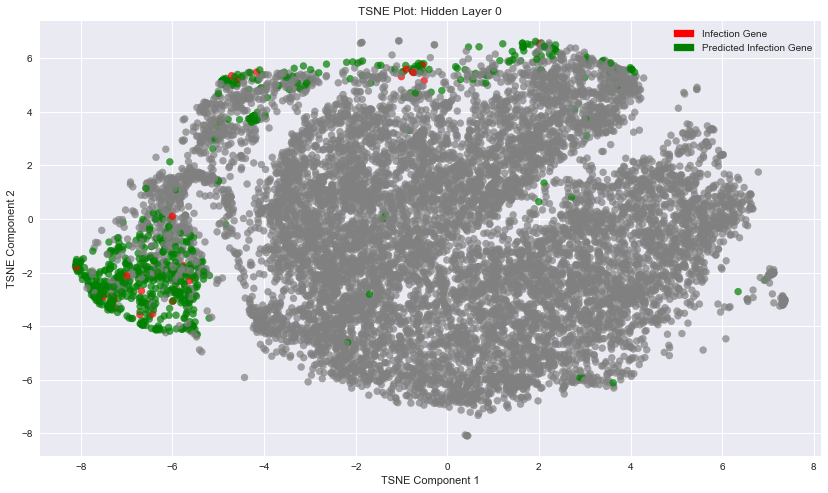

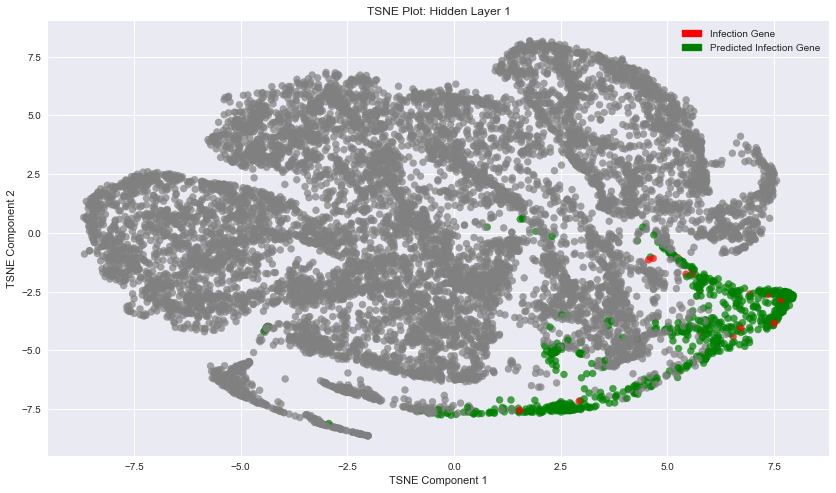

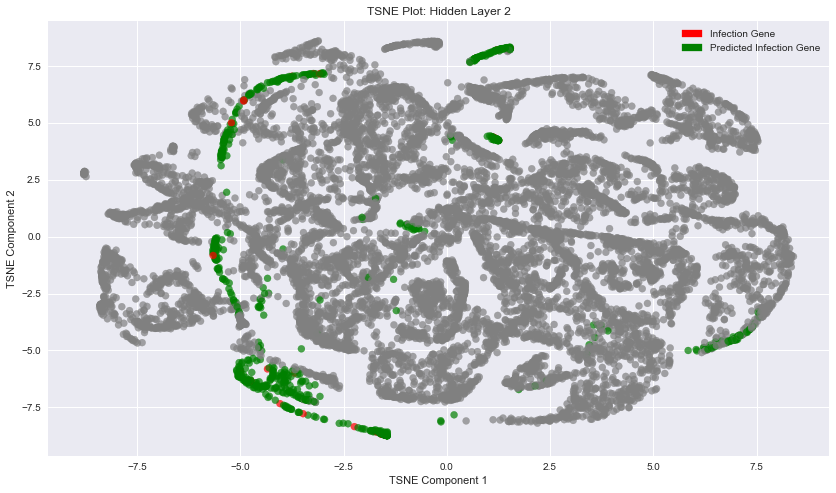

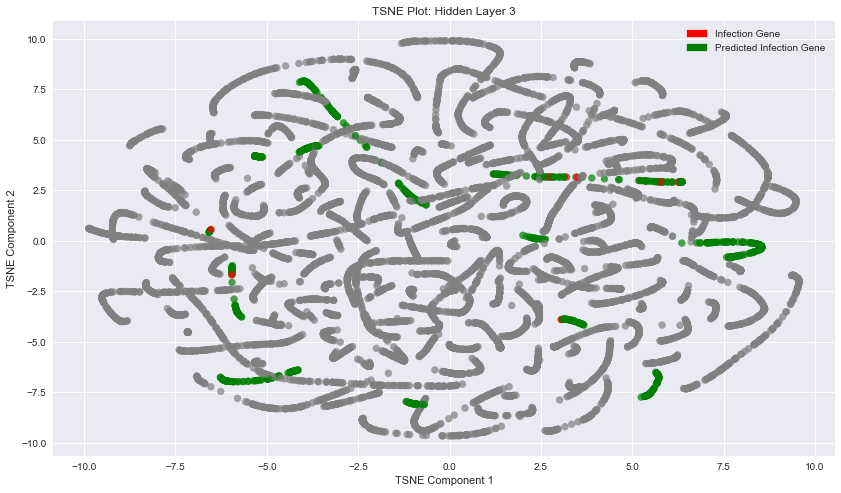

In [11]:
layer_num = 0
embeddings = []
for act in activations:
    if layer_num == 0:
        input_data = coo_matrix((act.values,
                                (act.indices[:, 0], act.indices[:, 1])),
                                shape=act.dense_shape)
        embedding = TSNE(n_components=2).fit_transform(input_data.todense())
    else:
        embedding = TSNE(n_components=2).fit_transform(act)
    embeddings.append(embedding)
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(layer_num))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])

    # save
    fig.savefig(model_dir + '/tsne_{}.png'.format(layer_num), dpi=300)
    layer_num += 1
    print ("Plotted TSNE for activation in layer {} successfully".format(layer_num))

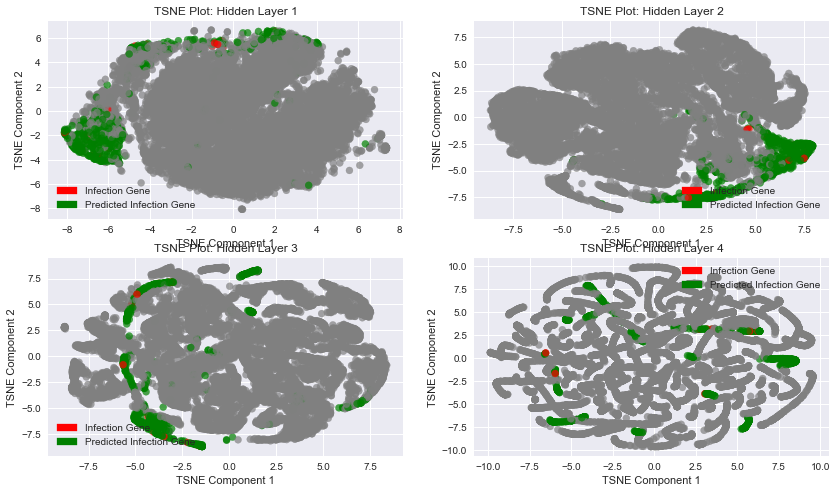

In [12]:
# one plot for all the TSNEs
fig = plt.figure(figsize=(14, 8))
x, y = bestSplit(len(embeddings))
count = 1
for embedding in embeddings:
    plt.subplot(x, y, count)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title('TSNE Plot: Hidden Layer {}'.format(count))

    # legend
    inf_genes = mpatches.Patch(color='red', label='Infection Gene')
    pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
    not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
    plt.legend(handles=[inf_genes, pred_genes])
    count += 1
fig.savefig('TSNE_all_layers.png', dpi=200)

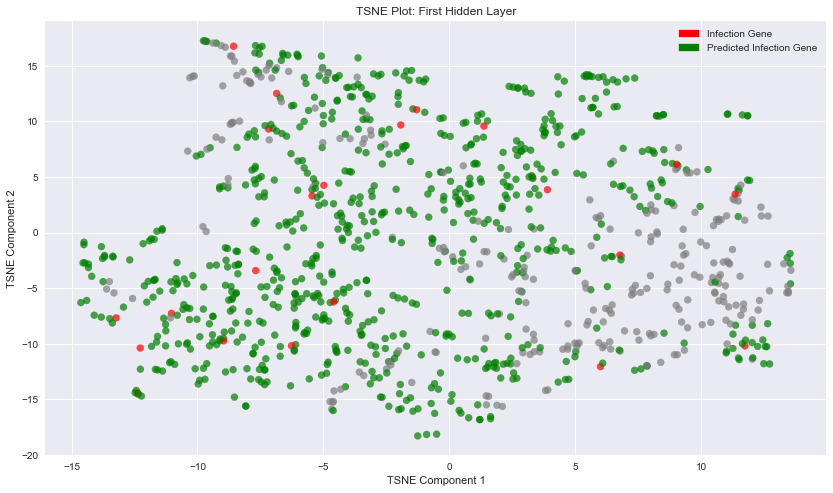

In [14]:
H_1_2d = TSNE(n_components=2).fit_transform(activations[2])

fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_2d[:, 0], H_1_2d[:, 1], c=preds_and_labels.color, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: First Hidden Layer')

# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
plt.legend(handles=[inf_genes, pred_genes])

# save
fig.savefig(model_dir + '/tsne_H1.png', dpi=300)

In [39]:
activations[0].indices.shape

(23363, 2)

In [43]:

input_data = coo_matrix((activations[0].values,
                        (activations[0].indices[:, 0], activations[0].indices[:, 1])),
                        shape=activations[0].dense_shape)
embedding = TSNE(n_components=2).fit_transform(input_data.todense())

<class 'numpy.ndarray'>
[1053   24]


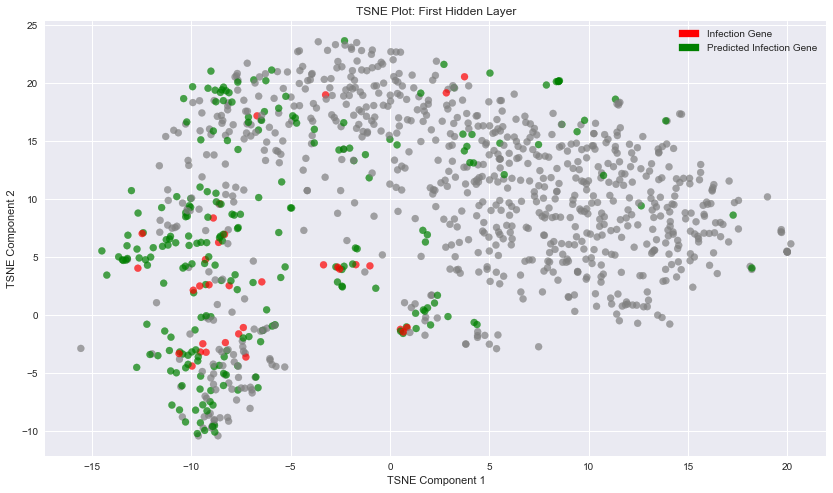

In [44]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=preds_and_labels.color, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: First Hidden Layer')

# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
plt.legend(handles=[inf_genes, pred_genes])

## Do the predictions have special properties?
I want to check the shortest path between predicted disease genes and true disease genes as well.
Further, I want to see them in a network.

In [ ]:
# build networkx graph with correct node names
G = nx.from_numpy_matrix(network)
#mapping = {i:node_names[i, 0] for i in range(node_names.shape[0])}
#nx.relabel_nodes(G, mapping, copy=False)

### Shortest Paths

In [ ]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_shortest_paths = nx.shortest_path_length(G)
sp_df = pd.DataFrame(dict(all_shortest_paths))

In [ ]:
# build views for label to label shortest paths and non-label to non-label
label_cond = sp_df.index.isin(predictions_for_knowns.index)
label_to_label = sp_df.loc[label_cond, label_cond]
nonlabel_to_nonlabel = sp_df.loc[~label_cond, ~label_cond]
label_to_nonlabel = sp_df.loc[~label_cond, label_cond]

In [ ]:
# plot the distributions
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 8, 1)

ltl = pd.Series(label_to_label.values.flatten()).dropna()
ntn = pd.Series(nonlabel_to_nonlabel.values.flatten()).dropna()
ltn = pd.Series(label_to_nonlabel.values.flatten()).dropna()
print (ltl.shape, ntn.shape, ltn.shape)
plt.hist(ltl, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection To Infection (mean {0:.2f})'.format(ltl.mean()))
plt.hist(ntn, bins=bins, alpha=.7, normed=True, color='gray',
         label='Non-Infection To Non-Infection (mean {0:.2f})'.format(ntn.mean()))
plt.hist(ltn, bins=bins, alpha=.3, normed=True, color='blue',
         label='Infection To Non-Infection (mean {0:.2f})'.format(ltn.mean()))
points = np.linspace(0, 8, 100)
plt.plot(points, mlab.normpdf(points, ltl.mean(), ltl.std()), color='red', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ntn.mean(), ntn.std()), color='gray', alpha=0.5)
plt.plot(points, mlab.normpdf(points, ltn.mean(), ltn.std()), color='blue', alpha=0.5)
plt.legend()
plt.title('Histograms of Shortest Paths between Infection Genes and Non-Infection Genes')
plt.xlabel('Shortest Path Length')
plt.ylabel('Normalized Frequency')
fig.savefig(model_dir + '/path_length_distribution.png')

### Node Degree

In [ ]:
# calculate shortest paths between all nodes and make it a dataframe matrix
all_node_degrees = G.degree()
degree_df = pd.Series(dict(all_node_degrees))

# build views for label and non-label degrees
label_cond = degree_df.index.isin(predictions_for_knowns.index)
labels = degree_df[label_cond]
nonlabels = degree_df[~label_cond]
print (labels.shape, nonlabels.shape)

# plot histograms
fig = plt.figure(figsize=(14, 8))
bins = np.arange(0, 50, 1)
plt.hist(labels, bins=bins, alpha=.5, normed=True, color='red',
         label='Infection Genes (Median {})'.format(labels.median()))
plt.hist(nonlabels, bins=bins, alpha=.7, normed=True, color='gray',
         label='Other Genes (Median {})'.format(nonlabels.median()))
plt.legend()
plt.title('Histograms of Node Degree for Infection and Other Genes')
plt.xlabel('Node Degree')
plt.ylabel('Normalized Frequency')
fig.savefig(model_dir + 'node_degrees.png')

### Probability that Neighbor of Infection Gene is also Infection Gene

In [ ]:
# half because of symmetric matrix
num_of_neighbor_labels = label_to_label[label_to_label == 1].count().sum() / 2
prob_neighbor_label = (num_of_neighbor_labels / label_to_label.shape[0]) * 100
print ("Chance of label to have labeled neighbor: {0:.2f} %".format(prob_neighbor_label))

In [ ]:
num_label_nbs = []
num_nbs = []
for label in predictions.index:
    nbs = list(nx.all_neighbors(G, label))
    label_nbs = predictions_for_knowns.index.isin(nbs).sum()
    num_label_nbs.append(label_nbs)
    num_nbs.append(len(nbs))
num_label_nbs = np.array(num_label_nbs)
num_total_nbs = np.array(num_nbs)
print ("Number of labeled neighbors: {}".format(num_label_nbs.sum()))
print ("Number of neighbors total: {}".format(num_total_nbs.sum()))
freq = num_label_nbs.sum()/num_total_nbs.sum()
print ("Chance that neighbor is labeled: {0:.4f}".format(freq))

## Visualize the Filters

In [ ]:
flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 150, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 40, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.6, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 50, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
flags.DEFINE_bool('cheby', True, 'Using Chebyshev convolutions or not.')

In [ ]:
adj = csr_matrix(network)
F = lil_matrix(features)
F = preprocess_features(F)
support = chebyshev_polynomials(adj, 2)
print (len(support))
print ([s[2] for s in support])

In [ ]:
tf.reset_default_graph()
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(1+FLAGS.max_degree)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features.shape, dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, 2)),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

def predict(features, support, labels, mask, placeholders):
    feed_dict_pred = construct_feed_dict(features, support, labels, mask, placeholders)
    pred = sess.run(model.predict(), feed_dict=feed_dict_pred)
    return pred

weights_layer_0 = []
weights_layer_1 = []
with tf.Session() as sess:
    model = GCN(placeholders, input_dim=features.shape[1], logging=True)
    model.load(sess)
    for k in range(FLAGS.max_degree): # chebychev coefficients
        mat_name = 'gcn/graphconvolution_{}_vars/weights_{}:0'.format(1, k)
        weights_layer_0.append(model.vars[mat_name].eval())
        mat_name = 'gcn/graphconvolution_{}_vars/weights_{}:0'.format(2, k)
        weights_layer_1.append(model.vars[mat_name].eval())
    
    # predict for test set and catch activations in H_1, H_2
    feed_dict = construct_feed_dict(features=F,
                                    support=support,
                                    labels=y_train,
                                    labels_mask=train_mask,
                                    placeholders=placeholders
                                   )
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    #l = sess.run(model.loss, feed_dict=feed_dict)
    activation_0 = sess.run(model.activations[-2], feed_dict=feed_dict)
    activation_1 = sess.run(model.activations[-1], feed_dict=feed_dict)

## Plot Feature Importance

In [ ]:
def plot_weights_for_k(matrix, fname='kernel_activation'):
    fig = plt.figure(figsize=(14, 8))
    num_rows, num_cols = bestSplit(matrix.shape[1])
    for i in range(matrix.shape[1]):
        plt.subplot(num_rows, num_cols, i+1)
        plt.bar(np.arange(0, matrix.shape[0]), matrix[:, i])
    fig.savefig('{}/{}.png'.format(model_dir, fname))

weights_l0_sum = np.sum(weights_layer_0, axis=0)
print (weights_l0_sum.shape)
plot_weights_for_k(weights_l0_sum, 'filters_layer0_k0')

In [ ]:
weights_l1_sum = np.sum(weights_layer_1, axis=0)
plot_weights_for_k(weights_l1_sum, 'filters_layer1_sum')

## Visualize the activations
Next, I want to see if the activations cluster together, that is if the output from each of the layers is embedded nicely.

In [ ]:
predictions.head()

In [ ]:
preds_and_labels = labels_df.join(predictions)
pos_classified = preds_and_labels.Prob_pos >= CLASSIFICATION_THRESHOLD

# set the colors according to classes
preds_and_labels['color'] = 'gray'
preds_and_labels.loc[pos_classified, 'color'] = 'red'
preds_and_labels.loc[~preds_and_labels.label & pos_classified, 'color'] = 'green'
preds_and_labels.groupby('color').count()

In [ ]:
H_1_2d = TSNE(n_components=2).fit_transform(activation_0)

In [ ]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_2d[:, 0], H_1_2d[:, 1], c=preds_and_labels.color, alpha=0.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: First Hidden Layer')

# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
not_involved = mpatches.Patch(color='gray', label='Not Involved in Infection')
plt.legend(handles=[inf_genes, pred_genes])

# save
fig.savefig(model_dir + '/tsne_H1.png', dpi=300)

In [ ]:
H_2_2d = TSNE(n_components=2).fit_transform(activation_1)

In [ ]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_2_2d[:, 0], H_2_2d[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('TSNE Plot: Second Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/tsne_H2.png', dpi=300)

In [ ]:
H_1_pca = PCA(n_components=2).fit_transform(activation_0)
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_1_pca[:, 0], H_1_pca[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot: First Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/pca_H1.png', dpi=300)

In [ ]:
H_2_pca = PCA(n_components=2).fit_transform(activation_1)
fig = plt.figure(figsize=(14, 8))
plt.scatter(H_2_pca[:, 0], H_2_pca[:, 1], c=preds_and_labels.color, alpha=.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot: Second Hidden Layer')
# legend
inf_genes = mpatches.Patch(color='red', label='Infection Gene')
pred_genes = mpatches.Patch(color='green', label='Predicted Infection Gene')
plt.legend(handles=[inf_genes, pred_genes])
# save
fig.savefig(model_dir + '/pca_H2.png', dpi=300)

## Correlation with other methods
I will now try to see how similar my performance is to NetRank and PageRank.

In [ ]:
netrank_scores = pd.DataFrame.from_csv('../data/pagerank/netrank_scores.txt', header=0, sep='\t')
netrank_scores.rename(columns={'Rank': 'NetRank_Rank'})
predictions.sort_values('Prob_pos', ascending=False, inplace=True)
predictions['GCN_Rank'] = np.arange(1, predictions.shape[0]+1)
print ("Correlation Rank & Prob: {}".format(predictions.Prob_pos.corr(predictions.GCN_Rank)))

In [ ]:
netrank_with_predictions = predictions.join(netrank_scores, how='inner')
fig = plt.figure(figsize=(14, 14))
plt.scatter(netrank_with_predictions.GCN_Rank, netrank_with_predictions.Rank, color='gray')
lin = np.arange(1, netrank_with_predictions.shape[0]+1)
plt.plot(lin, lin, '--', color='black')

print ("Correlation between NetRank and GCN: {}".format(netrank_with_predictions.Rank.corr(netrank_with_predictions.GCN_Rank)))

In [ ]:
netrank_scores.head()